In [1]:
import foolbox as fb
import helpers.helpers as helpers
import helpers.experiment as experiment

74/74 [==============================] - 11s 155ms/step - loss: 2.3829 - accuracy: 0.2096
Epoch 1/100
74/74 [==============================] - 15s 209ms/step - loss: 1.8673 - accuracy: 0.3446 - val_loss: 2.9386 - val_accuracy: 0.1027 - lr: 0.0010
Epoch 2/100
74/74 [==============================] - 12s 168ms/step - loss: 1.7194 - accuracy: 0.4048 - val_loss: 3.1925 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 3/100
74/74 [==============================] - 12s 168ms/step - loss: 1.5748 - accuracy: 0.4550 - val_loss: 3.4583 - val_accuracy: 0.1485 - lr: 0.0010
Epoch 4/100
74/74 [==============================] - 12s 164ms/step - loss: 1.4500 - accuracy: 0.5139 - val_loss: 2.7630 - val_accuracy: 0.2367 - lr: 0.0010
Epoch 5/100
74/74 [==============================] - 12s 163ms/step - loss: 1.3102 - accuracy: 0.5612 - val_loss: 1.8690 - val_accuracy: 0.3641 - lr: 0.0010
Epoch 6/100
74/74 [==============================] - 12s 164ms/step - loss: 1.2231 - accuracy: 0.5871 - val_loss: 1.6851 - va

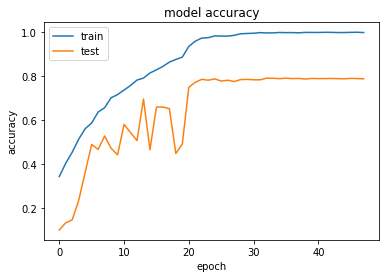

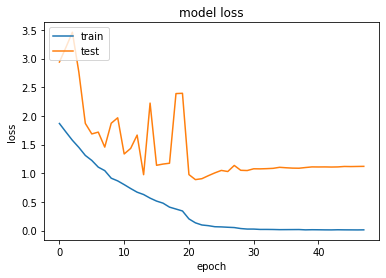

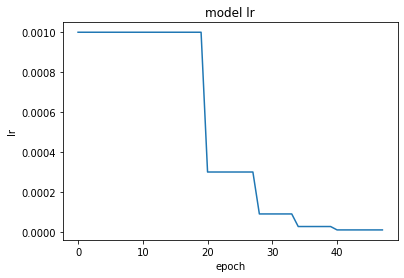

In [2]:
ds_train, ds_test, attack_images, attack_labels = experiment.load_data('100%')
model = helpers.initialize_base_model(ds_train,'',1, lr=1e-3)
hist = helpers.train_model(ds_train, ds_test,model)
helpers.plot_hist(hist)

In [3]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.L2CarliniWagnerAttack(
    binary_search_steps = 9,
    steps= 5000,
    stepsize = .01,
    confidence = 0,
    initial_const = 1000000,
    abort_early = True,
)

adversarials, _, batch_success = attack(
        fmodel,
        attack_images[:3],
        attack_labels[:3],
        epsilons=None
    )
l2_adv = adversarials[0]
l2_pert = (attack_images[0]-l2_adv)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [4]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
init_attack = fb.attacks.DatasetAttack()
BATCHSIZE = 64
batches = [
    (attack_images[:BATCHSIZE], attack_labels[:BATCHSIZE]), 
    (attack_images[BATCHSIZE:2*BATCHSIZE], attack_labels[BATCHSIZE:2*BATCHSIZE]),
    (attack_images[2*BATCHSIZE:3*BATCHSIZE], attack_labels[2*BATCHSIZE:3*BATCHSIZE]), 
    (attack_images[3*BATCHSIZE:4*BATCHSIZE], attack_labels[3*BATCHSIZE:4*BATCHSIZE])
]

init_attack = fb.attacks.DatasetAttack()

init_attack.feed(fmodel, batches[0][0])   # feed 1st batch of inputs
init_attack.feed(fmodel, batches[1][0])   # feed 2nd batch of inputs
init_attack.feed(fmodel, batches[2][0])   # feed 1st batch of inputs
init_attack.feed(fmodel, batches[3][0])   # feed 2nd batch of inputs
attack = fb.attacks.L0BrendelBethgeAttack(binary_search_steps=30, steps=500,lr_num_decay=30, lr=1e7, init_attack=init_attack)

adversarials, _, batch_success = attack(
    fmodel,
    attack_images[:3],
    criterion=fb.criteria.Misclassification(attack_labels[:3]),
    epsilons=[None]
)
l0_adv = adversarials[0][0]
l0_pert = (attack_images[0]-l0_adv)

In [5]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.LinfProjectedGradientDescentAttack()
res = [[],[],[],[],[],[]]
strengths = [0.125,0.25,0.5,1,2,4]


adversarials, _, success = attack(
    fmodel,
    attack_images[:3],
    attack_labels[:3],
    epsilons=8/255
)
l_inf_adv = adversarials[0]

l_inf_pert = (attack_images[0]-l_inf_adv)

In [ ]:
advs = {
    'l0':{
        'original':attack_images[0],
        'adversarial':l0_adv,
        'perturbation':l0_pert,
        'adversarial_class':5,
    },
    'l2':{
        'original':attack_images[0],
        'adversarial':l2_adv,
        'perturbation':l2_pert,
        'adversarial_class':8
    },
    'linf':{
        'original':attack_images[0],
        'adversarial':l_inf_adv,
        'perturbation':l_inf_pert,
        'adversarial_class':8
    },
}

import pickle
filename = 'advs'
outfile = open(filename,'wb')
pickle.dump(advs,outfile)
outfile.close()